# 残差分析

By Chris Fenaroli and Max Margenot 

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---



## 线性回归

线性回归是我们最基本的建模技术之一。我们用它来估计一组自变量$X_i$和一个因变量$y$之间的线性关系。我们的模型形式为:

$$ y_i = \beta_{0} 1 + \beta_{i, 1} x_{i, 1} + \dots + \beta_{i, p} x_{i, p} + \epsilon_i = x_i'\beta + \epsilon_i $$

对于$i \in \{1, \dots, n\}$，其中$n$是观测值的数量。我们把它写成向量形式:

$$ y = X\beta + \epsilon $$

其中$y$是一个$n \times 1$向量，$X$是一个$n \times p$矩阵，$\beta$是一个$p \times 1$系数向量，$\epsilon$是一个标准正态误差项。通常，我们称一个$p = 1$的模型为简单线性回归，称一个$p > = 1$的模型为多元线性回归。更多关于回归的背景信息可以查看以下课程[simple linear regression](https://www.quantopian.com/lectures#Linear-Regression) and [multiple linear regression](https://www.quantopian.com/lectures#Multiple-Linear-Regression).

无论何时我们构建一个模型，模型所预测的内容与样本中观察到的内容之间都会有差距。这些值之间的差异称为模型的残差，可以用来检查模型中的一些基本假设。检查的关键假设是:

* **线性拟合:** 潜在的关系应该是线性的
* **同方差:** 数据应该在方差中没有趋势
* **独立同分布:** 回归的残差应该是独立同分布的(i.i.d)，没有序列相关的迹象

我们可以使用残差来帮助诊断我们所估计的关系是真实的还是虚假的。

统计误差是与回归分析相关的类似度量，但有一个重要的区别:残差量化了回归模型预测与观察样本之间的差距，而统计误差则是回归模型与不可观测的期望值之间的差异。我们使用残差来估计这个误差。

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# 简单线性回归

首先，我们将定义一个执行线性回归并绘制结果的函数。

In [2]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * B1 + B0
    plt.scatter(X, Y, alpha=1) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=1);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model, B0, B1

Let's define a toy relationship between $X$ and $Y$ that we can model with a linear regression. Here we define the relationship and construct a model on it, drawing the determined line of best fit with the regression parameters.

Line of best fit: Y = 10.308876360394976 + 0.4931094837104808*X


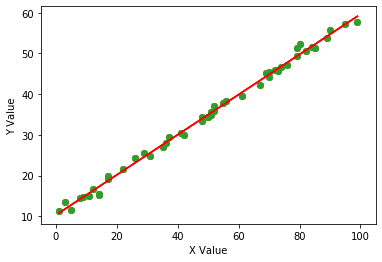

In [3]:
n = 50
X = np.random.randint(0, 100, n)
epsilon = np.random.normal(0, 1, n)

Y = 10 + 0.5 * X + epsilon

linreg(X,Y)[0];
print("Line of best fit: Y = {0} + {1}*X".format(linreg(X, Y)[1], linreg(X, Y)[2])) 

这个玩具样例有一些生成的噪音，但是所有真实的数据也会有噪音。这是在任何类型的野生数据生成过程中采样所固有的。因此，我们的最佳拟合线永远不会完全符合数据(这就是为什么它只是“最佳”，而不是“完美”)。拥有一个适合你所有观察结果的模型是[过度拟合](https://www.quantopian.com/lectures/the-of-overfitting)的必然标志。

对于所有的拟合模型，回归模型预测的结果与观察到的结果之间都存在差异，这就是残差的来源。

## 残差

残差的定义是样本中观察到的残差与回归预测的残差之间的差值。对于任何残差$r_i$，我们将其表示为

$$r_i = Y_i - \hat{Y_i}$$

其中$Y_i$是观察到的$Y$值，$\hat{Y}_i$是预测的Y值。我们将这些差异绘制在下图中:

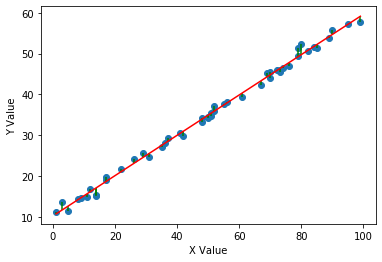

In [4]:
model, B0, B1 = linreg(X,Y)

residuals = model.resid
plt.errorbar(X,Y,xerr=0,yerr=[residuals,0*residuals],linestyle="None",color='Green');

我们可以直接从拟合的模型中提取残差。

In [5]:
residuals = model.resid
print (residuals)

[-0.18925081  1.2038232  -1.06165678  2.03498764  0.68338989  1.14874831
 -1.7237889  -0.31958137 -0.62669574  0.28840607 -0.61363058  1.10352397
 -0.71008961  0.92922108 -1.2054004   1.82513093 -1.07914152  0.50431591
 -0.03988687  0.21711755 -0.45341798 -0.04885228  0.41622979 -0.73242847
  0.01231565  0.01821388  0.55318641  0.06391775 -0.88561139  0.15412596
  0.39112768  0.35956288 -0.75344696 -0.70554548  0.04058729 -0.51174107
  0.05914682 -2.11055098 -0.91801436 -0.46183747 -0.92005786  0.98652641
 -0.23067936  0.51929227  2.4808277   1.23336113 -0.65763921  0.87951487
 -1.34582644  0.19817085]


# 诊断残差

有一个有效的线性回归模型所必需的许多假设都可以通过识别模型残差中的模式来加以检验。我们可以通过查看给定模型的残差图来进行快速的可视化检查。

使用残差图，我们查看模型的预测值和残差本身。我们想看到的只是一团不相关的点，就像这样:

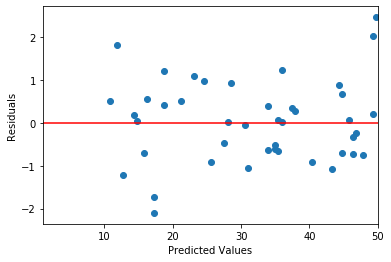

In [6]:
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.xlim([1,50]);

我们想要的是残差的随机分布。这些点不应该形成可辨别的图案。这将表明，一个简单的线性模型可能是一个很好的适合。如果我们看到任何一种趋势，这可能表明模型中存在自相关或异方差。

## 线性模型的适当性

通过在残差图中寻找模式，我们可以首先确定一个线性模型是否合适。简单的线性回归不适合于形式的基本关系:

$$Y = \beta_0 + \beta_1 X^2$$

作为一个线性函数不能完全解释$X$和$Y$之间的关系。

如果这个关系对线性模型不是很合适，那么残差图就会呈现出明显的模式。一般来说，线性回归在非线性关系上的残差图相对于残差= 0这条线是有偏的，是不对称的，而线性回归在线性关系上的残差图一般在残差= 0这条线上是对称的。

作为一个例子，让我们考虑变量$X$和$Y$之间包含一个二次项的新关系。

beta_0:  17.36994283145966
beta_1:  -2.261613664790011


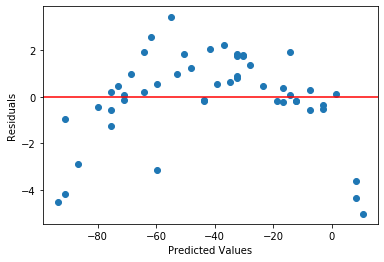

In [7]:
n = 50
X = np.random.randint(0, 50, n)
epsilon = np.random.normal(0, 1, n)
Y_nonlinear = 10 - X**1.2 + epsilon

model = sm.OLS(Y_nonlinear, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

print('beta_0: ', B0) 
print ('beta_1: ', B1)
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

由残差显示的“倒U”形状表明，非线性模型可能比线性模型更适合。

## 异方差性

线性回归背后的一个主要假设是基础数据有一个恒定的方差。如果数据的某些部分与其他部分存在差异，则该数据不适合进行线性回归。**异方差**是一个术语，指的是方差不恒定的数据，而不是方差恒定的同方差数据。

显著异方差通过偏置模型的标准误差使线性回归结果无效。因此，我们不能相信模型及其参数所产生的显著性检验和置信区间的结果。

为了避免这些后果，重要的是使用残差图来检查异方差并在必要时进行调整。

作为检测和纠正异方差的一个例子，让我们考虑$X$和$Y$之间的另一个关系:

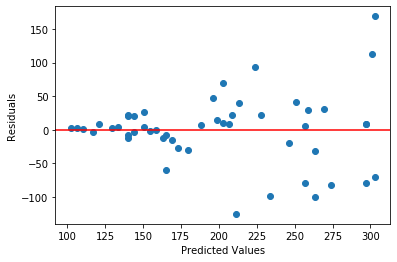

In [8]:
n = 50
X = np.random.randint(0, 100, n)
epsilon = np.random.normal(0, 1, n)
Y_heteroscedastic = 100 + 2*X + epsilon*X

model = sm.OLS(Y_heteroscedastic, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

异方差经常表现为这种扩散，给我们一个在一个方向上的锥形云。当我们沿着$x$轴移动时，残差的大小显然在增加。线性回归无法解释这种变化的变异性，回归的标准误差将是有偏的。

### 异方差检测的统计方法

一般来说，我们希望用定量的方法来支持对残差图的定性观察。残差图使我们相信数据可能是异方差的。让我们用统计检验来证实这个结果。

检验异方差是否存在的一种常用方法是Breusch-Pagan假设检验。将残差图的定性分析与至少一个假设检验的定量分析相结合是很好的。我们也可以添加White测试，但现在我们将只使用breusch-Pagan来测试我们的关系。`statsmodels`存在一个函数称为`het_breuschpagan`，简化了计算:

In [9]:
breusch_pagan_p = smd.het_breuschpagan(model.resid, model.model.exog)[1]
print(breusch_pagan_p) 
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.") 
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.") 

0.0004516823049752421
The relationship is heteroscedastic.


我们将置信水平设为$\alpha = 0.05$，因此，一个小于$0.05$的breusch-pagan p值告诉我们，这个关系是异方差的。关于假设检验和解释p值的更多信息，请参见[假设检验](https://www.quantopian.com/research/notebooks/cloned%20from%20%22quantopian%20lecture%20series%3a%20is%20testing%22.ipynb)。使用假设检验存在假阳性或假阴性的风险，这就是为什么如果我们持怀疑态度，用额外的检验来证实是有好处的。

### 调整异方差性

如果在创建了一个残差图并进行了测试之后，您认为自己具有异方差，那么您可以使用许多方法来尝试对其进行调整。我们将关注的三个方面是差分分析、对数转换和Box-Cox转换。

#### 差分分析

差分分析涉及到相邻值之间的一阶差分。这样，我们就能看到一个独立变量在不同时期的变化，而不是直接看它的值。通常，通过观察差异而不是原始值，我们可以消除异方差。我们可以对其进行修正，并对差分使用后续的模型。

In [10]:
# Finding first-order differences in Y_heteroscedastic
Y_heteroscedastic_diff = np.diff(Y_heteroscedastic)

现在我们已经将`Y_heteroscedastic`的一阶差分存储在了`Y_heteroscedastic_diff`中，让我们重复一下回归图和残差图，看看异方差是否仍然存在:

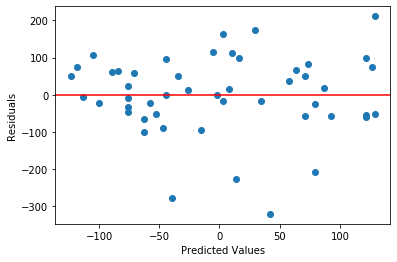

In [11]:
model = sm.OLS(Y_heteroscedastic_diff, sm.add_constant(X[1:])).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [13]:
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p) 
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.") 
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.") 

0.2722119636054444
The relationship is not heteroscedastic.


*注:本次新的回归是对数据之间的差异进行回归，因此回归输出必须进行反向转换才能达到原量表的预测。由于我们对差异进行了回归，我们可以将预测的差异加入到原始数据中，得到我们的估计:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y}_{diff}$$

#### 对数变换

接下来，我们对底层数据应用一个对数转换。对数变换将使残差更接近，并理想地消除异方差。在许多(虽然不是所有)情况下，对数转换足以稳定关系的方差。

In [14]:
# Taking the log of the previous data Y_heteroscedastic and saving it in Y_heteroscedastic_log
Y_heteroscedastic_log = np.log(Y_heteroscedastic)

现在我们已经在`Y_heteroscedastic_log`中存储了`y_heteroscededastic`的对数转换版本，让我们重复一下回归图和残差图，看看异方差是否仍然存在:

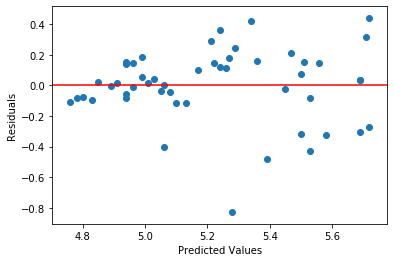

In [15]:
model = sm.OLS(Y_heteroscedastic_log, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [17]:
# Running and interpreting a Breusch-Pagan test
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p) 
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.") 
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.") 

0.05838366353232603
The relationship is not heteroscedastic.


*注:这次新的回归是在原始数据的对数上进行的。这意味着规模已经改变，回归估计将在这个转换后的规模。要将估计值恢复到原来的比例，您必须使用对数的逆函数对这些值进行反向转换:*

$$\hat{Y} = e^{\log(\hat{Y})}$$

#### Box-Cox转换

最后，我们研究Box-Cox转换。Box-Cox变换是一种功能强大的方法，可以处理多种类型的异方差关系。该过程通过测试$[- 5,5]$范围内的所有$\lambda$的值来查看是哪个值使得下面这个方程的输出最接近正态分布:
$$
Y^{(\lambda)} = \begin{cases}
    \frac{Y^{\lambda}-1}{\lambda} & : \lambda \neq 0\\ \log{Y} & : \lambda = 0
\end{cases}
$$

“最佳”$\lambda$将用于沿着上述函数转换系列。我们可以简单地使用`scipy`函数`boxcox`来代替手动完成所有这些工作。我们用这个来调整$Y$，希望能消除异方差。

*注意:Box-Cox转换只能在所有数据都是正数的情况下使用* 

In [18]:
# Finding a power transformation adjusted Y_heteroscedastic
Y_heteroscedastic_box_cox = stats.boxcox(Y_heteroscedastic)[0]

Now that we have stored the power transformed version of `Y_heteroscedastic` in `Y_heteroscedastic_prime` let's repeat the regression and residual plot to see if the heteroscedasticity is still present:

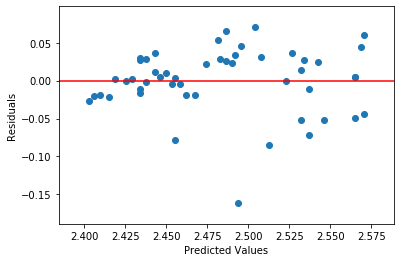

In [19]:
model = sm.OLS(Y_heteroscedastic_box_cox, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [21]:
# Running and interpreting a Breusch-Pagan test
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print(breusch_pagan_p) 
if breusch_pagan_p > 0.05:
    print("The relationship is not heteroscedastic.") 
if breusch_pagan_p < 0.05:
    print("The relationship is heteroscedastic.") 

0.2188180282986147
The relationship is not heteroscedastic.


*注意:既然这个关系不是异方差的，线性回归是合适的。但是，由于数据是经过幂变换的，因此回归估计的规模将不同于原始数据。这就是为什么重要的是要记住使用Box-Cox函数的反变换结果:*

$$\hat{Y} = (Y^{(\lambda)}\lambda + 1)^{1/\lambda}$$


### GARCH建模

另一种处理异方差的方法是通过GARCH(广义自回归条件异方差)模型。更多信息可以在[GARCH建模]中找到(https://www.quantopian.com/lectures#ARCH,-GARCH,-and-GMM)。

## 残差和自相关

线性回归背后的另一个假设是残差不是自相关的。当一个序列与它自身的延迟版本相关联时，它就是自相关的。一个潜在的自相关时间序列的例子就是日高温。今天的温度会让你对明天的温度有合理的把握(比如，如果今天是华氏90度，你可以非常确信明天不会低于冰点)。然而，一组公平的掷骰不会是自动相关的，因为看到一个掷骰不会给你下一个掷骰的信息。每一卷都与前一卷无关。

在金融领域，股票价格通常是自相关的，而股票收益则是独立的。我们表示时间依赖于之前的值，就像这样:

$$Y_i = Y_{i-1} + \epsilon$$

如果模型的残差是自相关的，那么您就能够对相邻的残差进行预测。在$Y$的情况下，我们知道数据将是自相关的，因为我们可以根据相邻的残差进行预测。

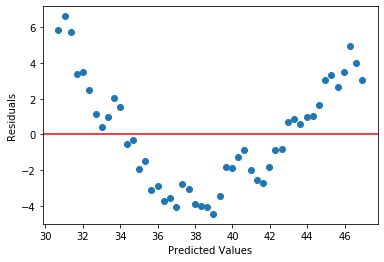

In [22]:
n = 50
X = np.linspace(0, n, n)
Y_autocorrelated = np.zeros(n)
Y_autocorrelated[0] = 50
for t in range(1, n):
    Y_autocorrelated[t] = Y_autocorrelated[t-1] + np.random.normal(0, 1) 

# Regressing X and Y_autocorrelated
model = sm.OLS(Y_autocorrelated, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

在这个例子中，残差中的自相关不是很明显，所以我们的检查更多的是为了确保绝对确定。

### 检测自相关的统计方法

与所有的统计特性一样，我们需要一个统计测试来最终确定我们的残差中是否存在自相关。为此，我们使用了Ljung-Box测试。

Ljung-Box测试用于检测时间序列中的自相关。Ljung-Box测试在低于指定最大值的所有滞后时间间隔内检查自相关，并返回包含每个测试滞后时间间隔的输出的数组。

让我们使用`statsmodels`中的`acorr_ljungbox`函数来测试上面模型的残差中的自相关。我们使用最大滞后区间$10$，看看是否有任何滞后有显著的自相关:

In [23]:
ljung_box = smd.acorr_ljungbox(residuals, lags = 10)
print("Lagrange Multiplier Statistics:", ljung_box[0]) 
print ("\nP-values:", ljung_box[1], "\n")

if any(ljung_box[1] < 0.05):
    print("The residuals are autocorrelated.") 
else:
    print ("The residuals are not autocorrelated.")

Lagrange Multiplier Statistics: [ 43.16841622  75.95921279  99.80065859 118.27607313 131.39995039
 140.87640304 147.8692779  153.02690998 155.75232619 156.41515714]

P-values: [5.02249196e-11 3.20380827e-17 1.71536733e-21 1.24688469e-24
 1.20074849e-26 6.54626957e-28 1.13728747e-28 4.57959843e-29
 5.65961973e-29 1.77892694e-28] 

The residuals are autocorrelated.


因为Ljung-Box测试在至少一个滞后区间内产生了低于$0.05$的p值，所以我们可以得出这样的结论:我们的模型的残差是自相关的。

## 调整自相关

我们可以用许多与调整异方差相同的方法来调整自相关。我们来看看一阶差分$Y$的模型是否存在自相关残差:

In [24]:
# Finding first-order differences in Y_autocorrelated
Y_autocorrelated_diff = np.diff(Y_autocorrelated)

P-values: [0.6352256  0.51327822 0.63885687 0.77005152 0.3857647  0.48635274
 0.59552625 0.35126189 0.44433903 0.47620994] 

The residuals are not autocorrelated.


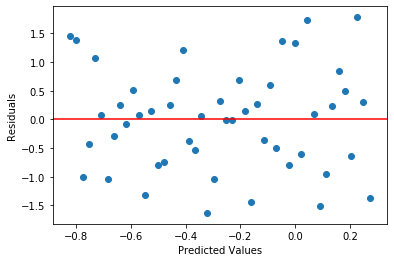

In [25]:
model = sm.OLS(Y_autocorrelated_diff, sm.add_constant(X[1:])).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

# Running and interpreting a Ljung-Box test
ljung_box = smd.acorr_ljungbox(residuals, lags = 10)
print ("P-values:", ljung_box[1], "\n")

if any(ljung_box[1] < 0.05):
    print("The residuals are autocorrelated.") 
else:
    print ("The residuals are not autocorrelated.")

*注:本次新的回归是对数据之间的差分进行回归，因此回归输出必须进行反向转换才能达到原量表的预测。由于我们对差异进行了回归，我们可以将预测的差异加入到原始数据中，得到我们的估计:*

$$\hat{Y_i} = Y_{i-1} + \hat{Y_{diff}}$$

我们也可以执行一个对数变换，如果我们这样选择的话。这个过程与我们在上面异方差数据上执行的过程相同，所以这次我们将不考虑它。

# 例如:市场贝塔计算

我们先用简单的线性回归计算TSLA和SPY之间的市场beta，然后对回归进行残差分析，以保证我们的结果的有效性。为了回归TSLA和SPY，我们将关注它们的回报率，而不是它们的价格，并将SPY的回报作为我们的自变量，TSLA的回报作为我们的结果变量。回归将给我们一条最合适的线:

$$\hat{r_{TSLA}} = \hat{\beta_0} + \hat{\beta_1}r_{SPY}$$

回归线$\hat{\beta_1}$的斜率将代表我们的市场贝塔值，对于SPY的收益每变化$r$%， TSLA的预期收益将变化$\hat{\beta_1}$。

让我们从对这两种资产的收益进行回归开始。

Estimated TSLA Beta: 1.9411397470619032


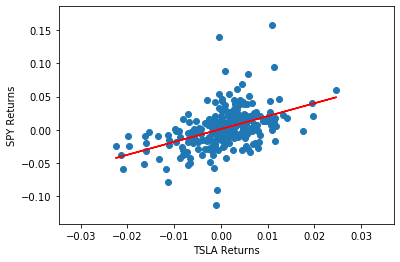

In [26]:
from pandas_datareader import data
start = '2014-01-01'
end = '2015-01-01'
asset = data.get_data_yahoo('TSLA', start, end)['Close']
benchmark = data.get_data_yahoo('SPY', start, end)['Close']

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:].values
r_b = benchmark.pct_change()[1:].values

# Regressing the benchmark b and asset a
r_b = sm.add_constant(r_b)
model = sm.OLS(r_a, r_b).fit()
r_b = r_b[:, 1]
B0, B1 = model.params

# Plotting the regression
A_hat = (B1*r_b + B0)
plt.scatter(r_b, r_a, alpha=1) # Plot the raw data
plt.plot(r_b, A_hat, 'r', alpha=1);  # Add the regression line, colored in red
plt.xlabel('TSLA Returns')
plt.ylabel('SPY Returns')

# Print our result
print("Estimated TSLA Beta:", B1) 

# Calculating the residuals
residuals = model.resid

我们的回归估计市场贝塔值为1.9253;根据回归，我们从SPY身上看到的每1%的回报，我们应该从TSLA中看到1.92%。

现在我们有了回归结果和残差，我们就可以进行残差分析了。我们的第一步将是绘制残差，并寻找任何危险信号:

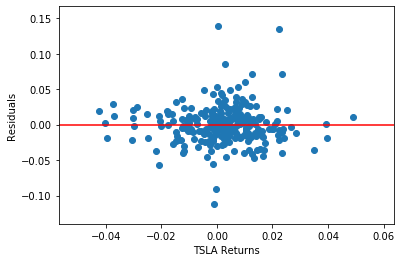

In [27]:
plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('TSLA Returns');
plt.ylabel('Residuals');

通过简单地观察残差的分布，似乎不存在任何异常。分布是相对随机的，没有模式可以观察到(围绕原点的集群是返回到围绕0的集群的自然结果，而不是一个危险信号)。我们的定性结论是，数据是同方差的，而不是自相关的，因此满足线性回归的假设。

### Breusch-Pagan异方差性检验

我们对残差图的定性评估很好地补充了一些统计测试。让我们从使用Breusch-Pagan测试来测试异方差性开始。使用`statsmodels`包的`het_breuschpagan`函数:

In [29]:
bp_test = smd.het_breuschpagan(residuals, model.model.exog)

print("Lagrange Multiplier Statistic:", bp_test[0]) 
print ("P-value:", bp_test[1])
print ("f-value:", bp_test[2])
print ("f_p-value:", bp_test[3], "\n")
if bp_test[1] > 0.05:
    print("The relationship is not heteroscedastic.") 
if bp_test[1] < 0.05:
    print ("The relationship is heteroscedastic.")

Lagrange Multiplier Statistic: 0.9511661593563452
P-value: 0.3294226390332469
f-value: 0.9471923697125405
f_p-value: 0.3313757079449806 

The relationship is not heteroscedastic.


由于p值大于0.05，我们没有足够的证据来拒绝原假设，即这种关系是同方差的。这个结果与我们定性的结论相吻合。

### Ljung-Box自相关测试

我们还使用Ljung-Box测试来定量地检查自相关。使用statsmodels包中的`acorr_ljungbox`函数和默认的最大延迟:

In [30]:
ljung_box = smd.acorr_ljungbox(r_a)
print("P-Values:", ljung_box[1], "\n") 
if any(ljung_box[1] < 0.05):
    print("The residuals are autocorrelated.") 
else:
    print ("The residuals are not autocorrelated.")

P-Values: [0.90157197 0.8959521  0.96355018 0.9628343  0.90459724 0.92076925
 0.95876742 0.97350935 0.98035757 0.98581366 0.98995223 0.96640185
 0.89825502 0.90805024 0.9316348  0.8628762  0.88686822 0.91582367
 0.9357676  0.87057273 0.87142408 0.90262246 0.88025478 0.90764523
 0.86580419 0.88763633 0.90507165 0.92289402 0.92746164 0.94500209
 0.89897792 0.92070343 0.93229128 0.93466736 0.93471149 0.94872693
 0.96040255 0.96025907 0.94302439 0.95403153] 

The residuals are not autocorrelated.


由于Ljung-Box检验得到所有滞后项的p值均大于0.05，因此我们可以得出残差不是自相关的结论。这个结果与我们定性的结论相吻合。

在对回归的残差图进行可视化评估并使用统计检验进行支持之后，我们可以得出结论:数据满足主要假设，线性模型是有效的.

## 参考
* "Analysis of Financial Time Series", by Ruey Tsay